# Sentiment Analysis - Model Training Notebook
## TF-IDF + Logistic Regression

In [7]:
"""
Este script realiza:
1. Carregamento dos dados limpos (JSON)
2. Transformação de textos em números com TF-IDF
3. Análise de features mais relevantes
4. Split treino/teste
5. Treinamento de Logistic Regression
6. Avaliação do modelo com múltiplas métricas
7. Serialização do modelo para produção
"""

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
import joblib
import warnings
import os

warnings.filterwarnings('ignore')

# Configurar estilo dos gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Todas as bibliotecas importadas com sucesso!")

✅ Todas as bibliotecas importadas com sucesso!


# CARREGAR DADOS LIMPOS

In [8]:
json_file = '../datasets/reviews_cleaned.json'

print(f"\n📁 Carregando arquivo: {json_file}")

with open(json_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)

print(f"✅ Dados carregados com sucesso!")
print(f"\n📊 Informações básicas:")
print(f"   Total de registros: {len(df):,}")
print(f"   Total de colunas: {len(df.columns)}")
print(f"   Colunas: {df.columns.tolist()}")
print(f"\n🔍 Primeiras 5 linhas:")
print(df.head())

# Verificar distribuição de sentimentos
print(f"\n📊 Distribuição de sentimentos:")
print(df['sentiment'].value_counts())
print(f"\nPercentuais:")
print(df['sentiment'].value_counts(normalize=True) * 100)


📁 Carregando arquivo: ../datasets/reviews_cleaned.json
✅ Dados carregados com sucesso!

📊 Informações básicas:
   Total de registros: 128,971
   Total de colunas: 3
   Colunas: ['text', 'sentiment', 'rating']

🔍 Primeiras 5 linhas:
                                                text sentiment  rating
0  estou contente com a compra entrega rapida o u...  Positivo       4
1  por apenas reu consegui comprar esse lindo cop...  Positivo       4
2  supera em agilidade e praticidade outras panel...  Positivo       4
3  meu filho amou parece de verdade com tantos de...  Positivo       4
4  a entrega foi no prazo as americanas estao de ...  Positivo       5

📊 Distribuição de sentimentos:
sentiment
Positivo    92894
Negativo    33571
Neutro       2506
Name: count, dtype: int64

Percentuais:
sentiment
Positivo    72.027045
Negativo    26.029883
Neutro       1.943072
Name: proportion, dtype: float64


# PREPARAR DADOS PARA MODELAGEM

In [9]:
# Converter sentimentos para labels numéricos
print(f"\n🔄 Convertendo sentimentos para labels numéricos...")

# Mapeamento: Negativo=0, Neutro=1, Positivo=2
sentiment_mapping = {
    'Negativo': 0,
    'Neutro': 1,
    'Positivo': 2
}

df['sentiment_label'] = df['sentiment'].map(sentiment_mapping)

print(f"✅ Mapeamento concluído:")
for sentiment, label in sentiment_mapping.items():
    count = (df['sentiment_label'] == label).sum()
    print(f"   {sentiment:12} → {label} ({count:,} registros)")

# Separar features (X) e target (y)
X = df['text']
y = df['sentiment_label']

print(f"\n📋 Dados preparados:")
print(f"   Features (X): {X.shape}")
print(f"   Target (y): {y.shape}")



🔄 Convertendo sentimentos para labels numéricos...
✅ Mapeamento concluído:
   Negativo     → 0 (33,571 registros)
   Neutro       → 1 (2,506 registros)
   Positivo     → 2 (92,894 registros)

📋 Dados preparados:
   Features (X): (128971,)
   Target (y): (128971,)


# VETORIZAÇÃO COM TF-IDF

In [10]:
print(f"\n🔄 Treinando TF-IDF Vectorizer...")
print(f"   Parâmetros:")
print(f"   - max_features: 1000")
print(f"   - ngram_range: (1, 2)")
print(f"   - stop_words: None")
print(f"   - min_df: 5")
print(f"   - max_df: 0.7")

# Criar e treinar TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),
    stop_words=None, #Nao funcionou com portugues, usar portugues em versoes futuras do sklearn
    min_df=5,
    max_df=0.7,
    lowercase=True,
    strip_accents='unicode'
)

X_tfidf = tfidf_vectorizer.fit_transform(X)

print(f"\n✅ TF-IDF treinado com sucesso!")
print(f"   Dimensões: {X_tfidf.shape}")
print(f"   Número de features: {len(tfidf_vectorizer.get_feature_names_out())}")

# Obter os nomes das features
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\n📝 Amostra de features (palavras/n-gramas):")
print(feature_names[:20])


🔄 Treinando TF-IDF Vectorizer...
   Parâmetros:
   - max_features: 1000
   - ngram_range: (1, 2)
   - stop_words: None
   - min_df: 5
   - max_df: 0.7

✅ TF-IDF treinado com sucesso!
   Dimensões: (128971, 1000)
   Número de features: 1000

📝 Amostra de features (palavras/n-gramas):
['abrir' 'absurdo' 'acabamento' 'acessivel' 'achei' 'achei que' 'acho'
 'acho que' 'acordo' 'acordo com' 'acredito' 'adorei' 'adorei produto'
 'adorou' 'agilidade' 'agora' 'agora nada' 'agora nao' 'agua' 'aguardando']


# ANÁLISE DAS FEATURES MAIS IMPORTANTES


📊 Top 30 features mais importantes (por TF-IDF médio):
  Feature  TF-IDF Médio
       de      0.056882
  produto      0.052799
      nao      0.048792
    muito      0.048341
      que      0.043387
       do      0.036991
      com      0.034108
      bom      0.031607
recomendo      0.030783
     para      0.030759
       um      0.028955
  entrega      0.026550
       da      0.023783
excelente      0.023002
qualidade      0.022738
       no      0.022447
      bem      0.022218
       em      0.021643
    otimo      0.021264
    prazo      0.020645
   chegou      0.020574
muito bom      0.020370
       na      0.019860
       as      0.019491
      mas      0.019339
     mais      0.019275
      uma      0.018658
    antes      0.017588
   gostei      0.017016
    super      0.016964


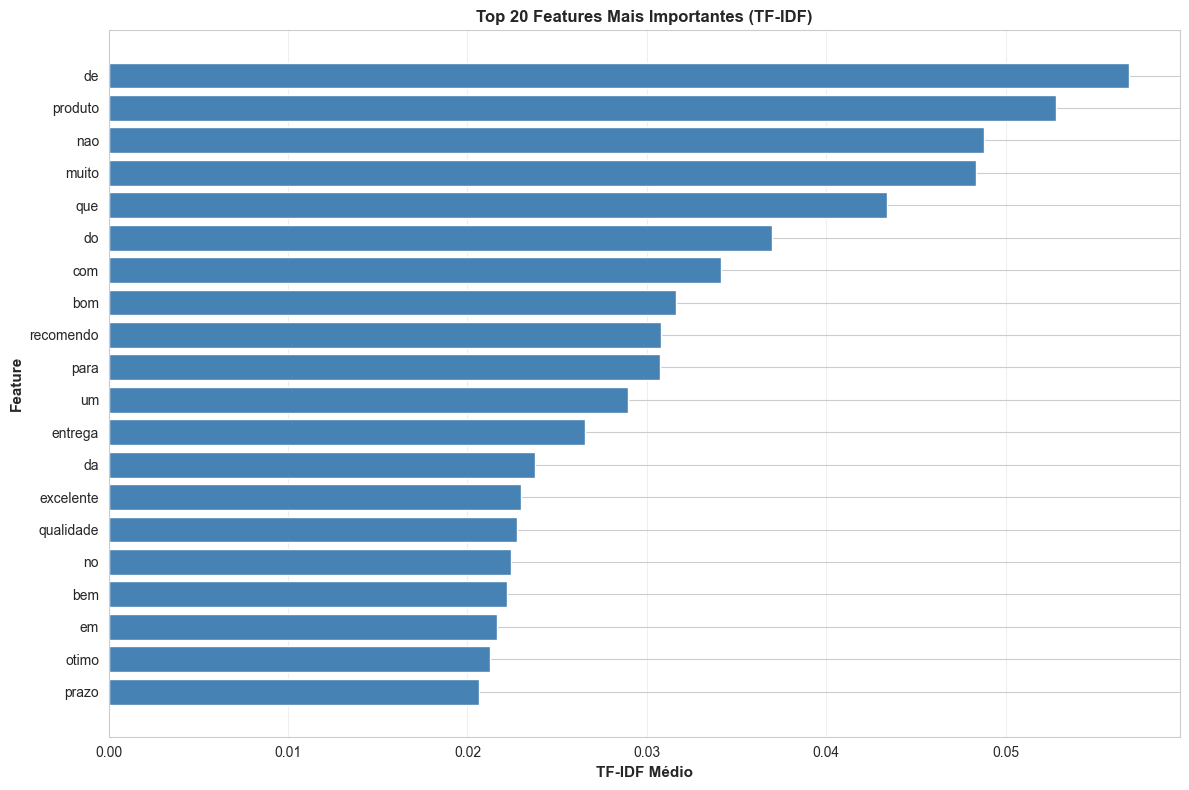


✅ Gráfico de features exibido!


In [11]:
# Calcular a média TF-IDF de cada feature
tfidf_mean = np.asarray(X_tfidf.mean(axis=0)).flatten()
feature_importance = sorted(zip(feature_names, tfidf_mean), key=lambda x: x[1], reverse=True)

print(f"\n📊 Top 30 features mais importantes (por TF-IDF médio):")
print("="*80)

top_features_df = pd.DataFrame(feature_importance[:30], columns=['Feature', 'TF-IDF Médio'])
print(top_features_df.to_string(index=False))

# Gráfico das top features
fig, ax = plt.subplots(figsize=(12, 8))

top_20_features = feature_importance[:20]
features = [f[0] for f in top_20_features]
importances = [f[1] for f in top_20_features]

ax.barh(features, importances, color='steelblue')
ax.set_xlabel('TF-IDF Médio', fontsize=11, fontweight='bold')
ax.set_ylabel('Feature', fontsize=11, fontweight='bold')
ax.set_title('Top 20 Features Mais Importantes (TF-IDF)', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()
print(f"\n✅ Gráfico de features exibido!")


## CALCULAR SAMPLE_WEIGHT PARA PRIORIZAR PALAVRAS NEGATIVAS

In [12]:

# Dicionário de palavras negativas (com pesos)
negative_keywords = {
    'péssimo': 3, 'horrível': 3, 'terrível': 3, 'pior': 2, 'ruim': 2,
    'quebrou': 3, 'quebrado': 3, 'problema': 2, 'problemas': 2,
    'não funciona': 3, 'não recomendo': 3, 'decepção': 2, 'insatisfeito': 2,
    'defeito': 3, 'defeitoso': 3, 'falha': 2, 'falho': 2,
    'lixo': 3, 'desperdício': 2, 'arrependido': 2, 'arrependimento': 2,
    'fraude': 3, 'enganado': 3, 'golpe': 3, 'enganação': 3
}

def count_negative_words(text):
    """Contar palavras negativas no texto"""
    text_lower = text.lower()
    return sum(weight for word, weight in negative_keywords.items() if word in text_lower)

# Calcular peso de negatividade para cada amostra
df['negative_word_count'] = df['text'].apply(count_negative_words)

# Criar sample_weight para dar mais importância aos textos com palavras negativas claras
def calculate_sample_weight(row):
    base_weight = 1.0
    
    # Se o texto é negativo e tem palavras negativas, aumentar peso
    if row['sentiment'] == 'Negativo' and row['negative_word_count'] > 0:
        base_weight = 1.5 + (row['negative_word_count'] * 0.3)  # Até 5x mais peso
    
    # Se o texto é positivo e tem palavras negativas, reduzir peso (caso ambíguo)
    elif row['sentiment'] == 'Positivo' and row['negative_word_count'] > 0:
        base_weight = 0.5  # Menos peso em casos contraditórios
    
    return min(base_weight, 5.0)  # Limitar a 5x peso máximo

df['sample_weight'] = df.apply(calculate_sample_weight, axis=1)

print(f"\n📊 Análise de Pesos de Treino:")
print(f"   Peso médio: {df['sample_weight'].mean():.2f}")
print(f"   Peso máximo: {df['sample_weight'].max():.2f}")
print(f"   Peso mínimo: {df['sample_weight'].min():.2f}")
print(f"   Desvio padrão: {df['sample_weight'].std():.2f}")

print(f"\n✅ Sample weights calculados!")


📊 Análise de Pesos de Treino:
   Peso médio: 1.06
   Peso máximo: 4.80
   Peso mínimo: 0.50
   Desvio padrão: 0.35

✅ Sample weights calculados!


# SPLIT TREINO/TESTE

In [13]:
print(f"\n🔄 Dividindo dados em treino (80%) e teste (20%)...")

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X_tfidf,
    y,
    df['sample_weight'],
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"✅ Split realizado com sucesso!")
print(f"\n📊 Distribuição dos dados:")
print(f"   Treino:")
print(f"      - Features: {X_train.shape}")
print(f"      - Sentimentos:")
for sentiment, label in sentiment_mapping.items():
    count = (y_train == label).sum()
    percent = count / len(y_train) * 100
    print(f"         {sentiment:12} → {count:,} ({percent:.2f}%)")

print(f"\n   Teste:")
print(f"      - Features: {X_test.shape}")
print(f"      - Sentimentos:")
for sentiment, label in sentiment_mapping.items():
    count = (y_test == label).sum()
    percent = count / len(y_test) * 100
    print(f"         {sentiment:12} → {count:,} ({percent:.2f}%)")




🔄 Dividindo dados em treino (80%) e teste (20%)...
✅ Split realizado com sucesso!

📊 Distribuição dos dados:
   Treino:
      - Features: (103176, 1000)
      - Sentimentos:
         Negativo     → 26,856 (26.03%)
         Neutro       → 2,005 (1.94%)
         Positivo     → 74,315 (72.03%)

   Teste:
      - Features: (25795, 1000)
      - Sentimentos:
         Negativo     → 6,715 (26.03%)
         Neutro       → 501 (1.94%)
         Positivo     → 18,579 (72.03%)


# TREINAMENTO DO MODELO

In [14]:
print(f"\n🔄 Treinando Logistic Regression...")
print(f"   Parâmetros:")
print(f"   - max_iter: 1000")
print(f"   - random_state: 42")
print(f"   - solver: lbfgs")
print(f"   - class_weight: balanced")
print(f"   - sample_weight: Custom (prioriza palavras negativas)")

model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs',
    class_weight='balanced'
)

# Treinar COM sample_weight para priorizar palavras negativas
model.fit(X_train, y_train, sample_weight=w_train)

print(f"✅ Modelo treinado com sucesso!")


🔄 Treinando Logistic Regression...
   Parâmetros:
   - max_iter: 1000
   - random_state: 42
   - solver: lbfgs
   - class_weight: balanced
   - sample_weight: Custom (prioriza palavras negativas)
✅ Modelo treinado com sucesso!


# PREDIÇÕES

In [15]:
print(f"\n🔄 Realizando predições...")

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

y_pred_proba_train = model.predict_proba(X_train)
y_pred_proba_test = model.predict_proba(X_test)

print(f"✅ Predições realizadas!")
print(f"   Treino: {y_pred_train.shape[0]:,}")
print(f"   Teste: {y_pred_test.shape[0]:,}")




🔄 Realizando predições...
✅ Predições realizadas!
   Treino: 103,176
   Teste: 25,795


# AVALIAÇÃO DO MODELO


📊 MÉTRICAS NO CONJUNTO DE TREINO:
--------------------------------------------------------------------------------
   Acurácia:  0.7854
   Precisão:  0.9281
   Recall:    0.7854
   F1-Score:  0.8446

📊 MÉTRICAS NO CONJUNTO DE TESTE:
--------------------------------------------------------------------------------
   Acurácia:  0.7763
   Precisão:  0.9209
   Recall:    0.7763
   F1-Score:  0.8377

📊 RELATÓRIO DETALHADO POR SENTIMENTO (Teste):
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negativo     0.8357    0.7498    0.7904      6715
      Neutro     0.0541    0.5030    0.0977       501
    Positivo     0.9751    0.7932    0.8748     18579

    accuracy                         0.7763     25795
   macro avg     0.6216    0.6820    0.5876     25795
weighted avg     0.9209    0.7763    0.8377     25795


📊 MATRIZ DE CONFUSÃO (Teste):
-------------------------------------------------------------

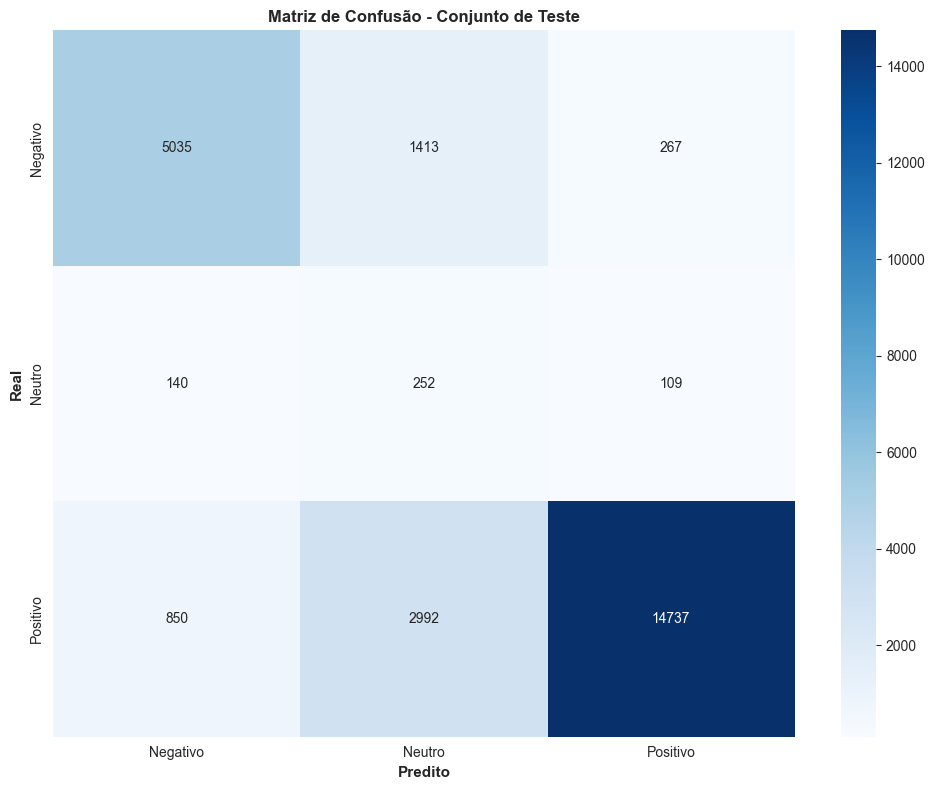


✅ Matriz de confusão exibida!

📊 COMPARAÇÃO TREINO vs TESTE:
--------------------------------------------------------------------------------
 Métrica   Treino    Teste
Acurácia 0.785444 0.776274
Precisão 0.928060 0.920934
  Recall 0.785444 0.776274
F1-Score 0.844627 0.837747


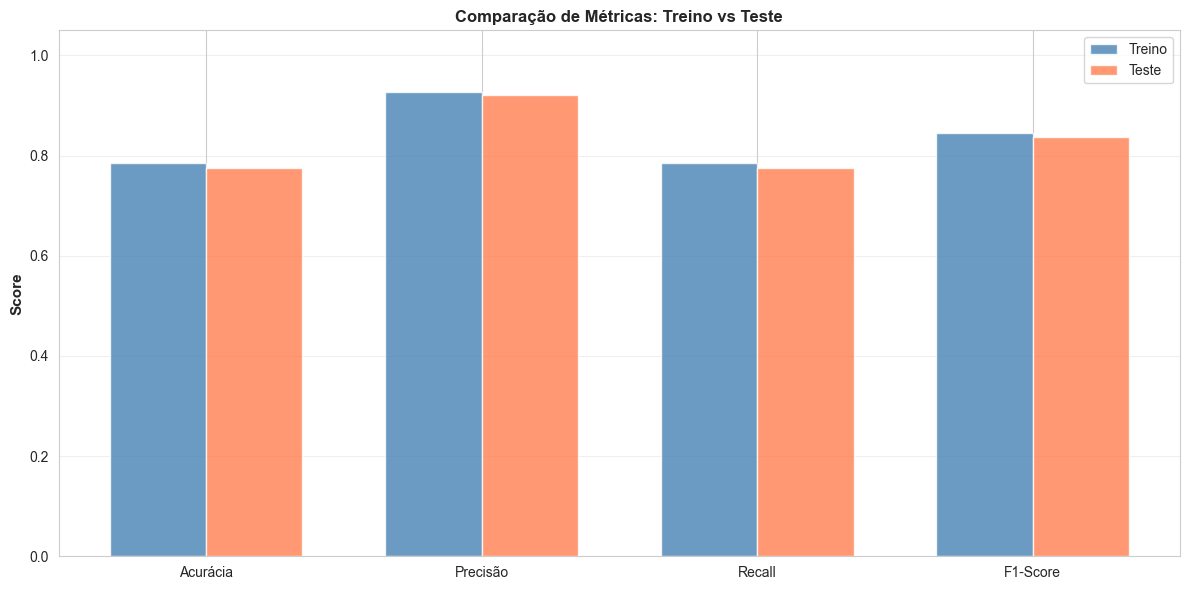


✅ Gráfico de comparação exibido!


In [16]:
# Métricas no conjunto de TREINO
print(f"\n📊 MÉTRICAS NO CONJUNTO DE TREINO:")
print("-"*80)

accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='weighted')
recall_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')

print(f"   Acurácia:  {accuracy_train:.4f}")
print(f"   Precisão:  {precision_train:.4f}")
print(f"   Recall:    {recall_train:.4f}")
print(f"   F1-Score:  {f1_train:.4f}")

# Métricas no conjunto de TESTE
print(f"\n📊 MÉTRICAS NO CONJUNTO DE TESTE:")
print("-"*80)

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

print(f"   Acurácia:  {accuracy_test:.4f}")
print(f"   Precisão:  {precision_test:.4f}")
print(f"   Recall:    {recall_test:.4f}")
print(f"   F1-Score:  {f1_test:.4f}")

# Relatório detalhado por classe
print(f"\n📊 RELATÓRIO DETALHADO POR SENTIMENTO (Teste):")
print("-"*80)

class_names = [k for k, v in sorted(sentiment_mapping.items(), key=lambda x: x[1])]
report = classification_report(y_test, y_pred_test, target_names=class_names, digits=4)
print(report)

# Matriz de confusão
print(f"\n📊 MATRIZ DE CONFUSÃO (Teste):")
print("-"*80)

cm = confusion_matrix(y_test, y_pred_test)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print(cm_df)

# Visualizar matriz de confusão
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax, 
            xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predito', fontsize=11, fontweight='bold')
ax.set_ylabel('Real', fontsize=11, fontweight='bold')
ax.set_title('Matriz de Confusão - Conjunto de Teste', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()
print(f"\n✅ Matriz de confusão exibida!")

# Comparar métricas treino vs teste
print(f"\n📊 COMPARAÇÃO TREINO vs TESTE:")
print("-"*80)

comparison = pd.DataFrame({
    'Métrica': ['Acurácia', 'Precisão', 'Recall', 'F1-Score'],
    'Treino': [accuracy_train, precision_train, recall_train, f1_train],
    'Teste': [accuracy_test, precision_test, recall_test, f1_test]
})

print(comparison.to_string(index=False))

# Gráfico de comparação
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison))
width = 0.35

ax.bar(x - width/2, comparison['Treino'], width, label='Treino', color='steelblue', alpha=0.8)
ax.bar(x + width/2, comparison['Teste'], width, label='Teste', color='coral', alpha=0.8)

ax.set_ylabel('Score', fontsize=11, fontweight='bold')
ax.set_title('Comparação de Métricas: Treino vs Teste', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison['Métrica'])
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()
print(f"\n✅ Gráfico de comparação exibido!")


# CURVA ROC-AUC (Para classificação binária: Positivo vs Resto)


📊 ROC-AUC Score (Positivo vs Resto):
   AUC: 0.9538


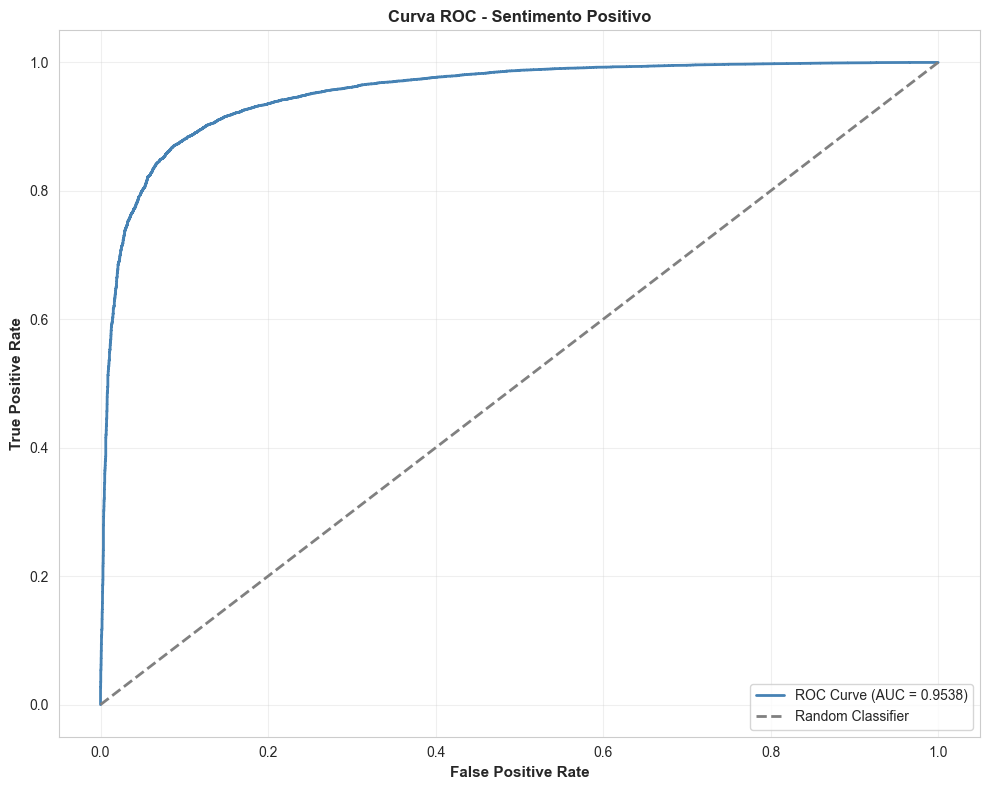


✅ Curva ROC exibida!


In [17]:
# Converter para problema binário: Positivo (1) vs Resto (0)
y_test_binary = (y_test == 2).astype(int)  # 2 é Positivo
y_pred_proba_positive = y_pred_proba_test[:, 2]  # Probabilidade de Positivo

auc_score = roc_auc_score(y_test_binary, y_pred_proba_positive)

print(f"\n📊 ROC-AUC Score (Positivo vs Resto):")
print(f"   AUC: {auc_score:.4f}")

# Plotar curva ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_proba_positive)

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(fpr, tpr, color='steelblue', lw=2, label=f'ROC Curve (AUC = {auc_score:.4f})')
ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')

ax.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
ax.set_title('Curva ROC - Sentimento Positivo', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()
print(f"\n✅ Curva ROC exibida!")


# EXEMPLOS DE PREDIÇÕES

In [18]:
print(f"\n🔍 EXEMPLOS DE PREDIÇÕES DO CONJUNTO DE TESTE:")
print("="*80)

reverse_mapping = {v: k for k, v in sentiment_mapping.items()}

# Pegar alguns índices aleatórios
indices_to_show = np.random.choice(len(y_test), size=5, replace=False)

for idx, test_idx in enumerate(indices_to_show, 1):
    # Obter o texto original
    original_idx = df.index[y.index[test_idx]]
    test_text = df.loc[original_idx, 'text']
    
    real_label = y_test.iloc[test_idx]
    pred_label = y_pred_test[test_idx]
    pred_proba = y_pred_proba_test[test_idx]
    
    real_sentiment = reverse_mapping[real_label]
    pred_sentiment = reverse_mapping[pred_label]
    
    print(f"\nExemplo {idx}:")
    print(f"   Texto: \"{test_text[:100]}...\"")
    print(f"   Real:      {real_sentiment:12} (probabilidade: {pred_proba[real_label]:.4f})")
    print(f"   Predito:   {pred_sentiment:12} (probabilidade: {pred_proba[pred_label]:.4f})")
    print(f"   Confiança: {np.max(pred_proba):.4f}")
    
    if real_label == pred_label:
        print(f"   Status:    ✅ CORRETO")
    else:
        print(f"   Status:    ❌ INCORRETO")


🔍 EXEMPLOS DE PREDIÇÕES DO CONJUNTO DE TESTE:

Exemplo 1:
   Texto: "fiz questao de avaliar porque meu filho usou essa cadeira ate os anos fizemos varias viagens e ela o..."
   Real:      Positivo     (probabilidade: 0.6396)
   Predito:   Positivo     (probabilidade: 0.6396)
   Confiança: 0.6396
   Status:    ✅ CORRETO

Exemplo 2:
   Texto: "ainda que a compra foi recente mas dar para avaliar que e muito boa recomendo..."
   Real:      Neutro       (probabilidade: 0.4908)
   Predito:   Neutro       (probabilidade: 0.4908)
   Confiança: 0.4908
   Status:    ✅ CORRETO

Exemplo 3:
   Texto: "excelente custo beneficio com esse preco dei pra minha familia todarecomendo..."
   Real:      Positivo     (probabilidade: 0.9934)
   Predito:   Positivo     (probabilidade: 0.9934)
   Confiança: 0.9934
   Status:    ✅ CORRETO

Exemplo 4:
   Texto: "notebook em compaq presario cq intel dual core gb gb tela windowns touch branco e excelente veio no ..."
   Real:      Positivo     (probabilidade: 0.39

# SERIALIZAR MODELOS PARA PRODUÇÃO

In [19]:
# Salvar TF-IDF Vectorizer
tfidf_model_path = '../models/tfidf_vectorizer.joblib'
print(f"\n💾 Salvando TF-IDF Vectorizer...")
joblib.dump(tfidf_vectorizer, tfidf_model_path)
print(f"✅ Salvo em: {tfidf_model_path}")
print(f"   Tamanho: {os.path.getsize(tfidf_model_path) / 1024:.2f} KB")

# Salvar Logistic Regression Model
model_path = '../models/logistic_regression_model.joblib'
print(f"\n💾 Salvando Logistic Regression Model...")
joblib.dump(model, model_path)
print(f"✅ Salvo em: {model_path}")
print(f"   Tamanho: {os.path.getsize(model_path) / 1024:.2f} KB")

# Salvar mapeamento de sentimentos
sentiment_mapping_path = '../models/sentiment_mapping.json'
print(f"\n💾 Salvando mapeamento de sentimentos...")
with open(sentiment_mapping_path, 'w') as f:
    json.dump(sentiment_mapping, f, ensure_ascii=False, indent=2)
print(f"✅ Salvo em: {sentiment_mapping_path}")

# Salvar metadata do modelo
metadata = {
    'model_type': 'Logistic Regression',
    'vectorizer_type': 'TF-IDF',
    'accuracy_test': float(accuracy_test),
    'precision_test': float(precision_test),
    'recall_test': float(recall_test),
    'f1_test': float(f1_test),
    'auc_test': float(auc_score),
    'num_features': len(feature_names),
    'num_classes': len(sentiment_mapping),
    'sentiment_mapping': sentiment_mapping,
    'classes': list(reverse_mapping.values())
}

metadata_path = '../models/model_metadata.json'
print(f"\n💾 Salvando metadata do modelo...")
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)
print(f"✅ Salvo em: {metadata_path}")

# Salvar feature names (para usar na predição)
feature_names_path = '../models/feature_names.json'
print(f"\n💾 Salvando nomes de features...")
with open(feature_names_path, 'w') as f:
    json.dump(feature_names.tolist(), f, ensure_ascii=False, indent=2)
print(f"✅ Salvo em: {feature_names_path}")



💾 Salvando TF-IDF Vectorizer...
✅ Salvo em: ../models/tfidf_vectorizer.joblib
   Tamanho: 37.38 KB

💾 Salvando Logistic Regression Model...
✅ Salvo em: ../models/logistic_regression_model.joblib
   Tamanho: 24.31 KB

💾 Salvando mapeamento de sentimentos...
✅ Salvo em: ../models/sentiment_mapping.json

💾 Salvando metadata do modelo...
✅ Salvo em: ../models/model_metadata.json

💾 Salvando nomes de features...
✅ Salvo em: ../models/feature_names.json


# TESTAR CARREGAMENTO DOS MODELOS

In [20]:
print(f"\n🔄 Carregando modelos salvos...")

# Carregar TF-IDF
tfidf_loaded = joblib.load(tfidf_model_path)
print(f"✅ TF-IDF carregado com sucesso!")

# Carregar modelo
model_loaded = joblib.load(model_path)
print(f"✅ Modelo carregado com sucesso!")

# Carregar mapeamento
with open(sentiment_mapping_path, 'r') as f:
    sentiment_mapping_loaded = json.load(f)
print(f"✅ Mapeamento carregado com sucesso!")

# Testar predição com modelo carregado
print(f"\n🧪 Testando predição com modelos carregados...")

test_texts = [
    "Produto excelente! Superou minhas expectativas. Recomendo!",
    "Péssimo atendimento. Nunca mais compro aqui.",
    "Produto OK, nada de especial."
]

reverse_mapping_loaded = {v: k for k, v in sentiment_mapping_loaded.items()}

print(f"\n📝 TESTE DE PREDIÇÃO COM MODELOS CARREGADOS:")
print("="*80)

for i, text in enumerate(test_texts, 1):
    # Vetorizar
    text_tfidf = tfidf_loaded.transform([text])
    
    # Predizer
    pred_label = model_loaded.predict(text_tfidf)[0]
    pred_proba = model_loaded.predict_proba(text_tfidf)[0]
    
    sentiment = reverse_mapping_loaded[pred_label]
    confidence = np.max(pred_proba)
    
    print(f"\nTexto {i}: \"{text}\"")
    print(f"   Sentimento: {sentiment}")
    print(f"   Confiança: {confidence:.4f}")
    print(f"   Probabilidades:")
    for sentiment_name, prob in zip(sorted(reverse_mapping_loaded.values()), sorted(pred_proba)):
        print(f"      {sentiment_name:12} → {prob:.4f}")



🔄 Carregando modelos salvos...
✅ TF-IDF carregado com sucesso!
✅ Modelo carregado com sucesso!
✅ Mapeamento carregado com sucesso!

🧪 Testando predição com modelos carregados...

📝 TESTE DE PREDIÇÃO COM MODELOS CARREGADOS:

Texto 1: "Produto excelente! Superou minhas expectativas. Recomendo!"
   Sentimento: Positivo
   Confiança: 0.9578
   Probabilidades:
      Negativo     → 0.0001
      Neutro       → 0.0422
      Positivo     → 0.9578

Texto 2: "Péssimo atendimento. Nunca mais compro aqui."
   Sentimento: Negativo
   Confiança: 0.8329
   Probabilidades:
      Negativo     → 0.0282
      Neutro       → 0.1389
      Positivo     → 0.8329

Texto 3: "Produto OK, nada de especial."
   Sentimento: Positivo
   Confiança: 0.5573
   Probabilidades:
      Negativo     → 0.0788
      Neutro       → 0.3640
      Positivo     → 0.5573


# RESUMO FINAL

In [21]:
print(f"\n📊 DATASET:")
print(f"   • Total de registros: {len(df):,}")
print(f"   • Features: {X_tfidf.shape[1]}")
print(f"   • Classes: {len(sentiment_mapping)}")

print(f"\n📚 TREINAMENTO:")
print(f"   • Registros de treino: {X_train.shape[0]:,}")
print(f"   • Registros de teste: {X_test.shape[0]:,}")

print(f"\n🎯 RESULTADOS (Conjunto de Teste):")
print(f"   • Acurácia:  {accuracy_test:.4f}")
print(f"   • Precisão:  {precision_test:.4f}")
print(f"   • Recall:    {recall_test:.4f}")
print(f"   • F1-Score:  {f1_test:.4f}")
print(f"   • AUC (Positivo): {auc_score:.4f}")

print(f"\n📁 ARQUIVOS SALVOS:")
print(f"   ✅ {tfidf_model_path}")
print(f"   ✅ {model_path}")
print(f"   ✅ {sentiment_mapping_path}")
print(f"   ✅ {metadata_path}")
print(f"   ✅ {feature_names_path}")


print(f"\n" + "="*80)
print("✅ TREINAMENTO COMPLETO!")
print("="*80)


📊 DATASET:
   • Total de registros: 128,971
   • Features: 1000
   • Classes: 3

📚 TREINAMENTO:
   • Registros de treino: 103,176
   • Registros de teste: 25,795

🎯 RESULTADOS (Conjunto de Teste):
   • Acurácia:  0.7763
   • Precisão:  0.9209
   • Recall:    0.7763
   • F1-Score:  0.8377
   • AUC (Positivo): 0.9538

📁 ARQUIVOS SALVOS:
   ✅ ../models/tfidf_vectorizer.joblib
   ✅ ../models/logistic_regression_model.joblib
   ✅ ../models/sentiment_mapping.json
   ✅ ../models/model_metadata.json
   ✅ ../models/feature_names.json

✅ TREINAMENTO COMPLETO!
